In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set plot style for better visualization
sns.set_theme(style="whitegrid")

In [2]:
# ==============================================================
# 1️⃣ Load Dataset
# ==============================================================
# Make sure "emails_16_17_18_19.csv" is in the same folder
file_path = "emails_16_17_18_19.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully.")
    print("\nFirst 5 rows:")
    display(df.head())
    print(f"\nTotal shape: {df.shape}")

    # ==============================================================
    # 2️⃣ Preprocessing
    # ==============================================================
    # Clean column names (remove extra spaces)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    # Identify the Label column (Predicting Spam vs Not Spam)
    label_col = "Prediction"

    # Drop any rows that don't have a label
    df = df.dropna(subset=[label_col])

    # Identify features: All columns except 'Email No.' and 'Prediction'
    # This dataset likely has word counts as columns.
    feature_cols = [c for c in df.columns if c not in [label_col, "Email No."]]

    # Extract features (X) and target labels (y)
    # We use .values to get numpy arrays for our 'from scratch' implementation
    X = df[feature_cols].values
    y = df[label_col].values

    # Ensure labels are integers 0 and 1
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split into 80% train and 20% test
    # stratify=y ensures both train and test have similar ratio of spam/not spam
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\n✅ Data Preparation Complete.")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples:  {X_test.shape[0]}")
    print(f"Number of features (words): {X_train.shape[1]}")

except FileNotFoundError:
    print(f"❌ Error: File '{file_path}' not found. Please upload it.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

✅ Dataset loaded successfully.

First 5 rows:


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0



Total shape: (5172, 3002)

✅ Data Preparation Complete.
Training samples: 4137
Testing samples:  1035
Number of features (words): 3000


In [3]:
# ==============================================================
# 3️⃣ Multinomial Naïve Bayes (From Scratch)
# ==============================================================
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        # Alpha is for Laplace Smoothing to avoid zero probabilities
        self.alpha = alpha
        self.class_priors = None
        self.word_probs = None
        self.classes = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Initialize arrays to store probabilities
        self.class_priors = np.zeros(n_classes)
        self.word_probs = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            # Select only the rows that belong to class 'c'
            X_c = X[y == c]
            
            # 1. Calculate Prior Probability: P(class) = count(class) / total_samples
            self.class_priors[idx] = X_c.shape[0] / n_samples
            
            # 2. Calculate Conditional Probabilities: P(word | class)
            # Total count of EACH word in this class
            total_word_counts = np.sum(X_c, axis=0) 
            # Total count of ALL words in this class
            total_words_in_class = np.sum(total_word_counts)
            
            # Apply Laplace Smoothing: (count + alpha) / (total + alpha * num_features)
            self.word_probs[idx] = (total_word_counts + self.alpha) / \
                                   (total_words_in_class + self.alpha * n_features)

    def predict(self, X):
        y_pred = []
        # Loop through each email (sample) in X
        for x_sample in X:
            class_scores = []
            # Calculate score for each class
            for idx, c in enumerate(self.classes):
                # Use Log probabilities to prevent underflow (multiplying tiny numbers)
                # Score = log(P(class)) + SUM [ count(word) * log(P(word|class)) ]
                
                # Add a tiny epsilon to avoid log(0) if a word prob is somehow 0
                epsilon = 1e-9
                log_word_probs = np.log(self.word_probs[idx] + epsilon)
                
                score = np.log(self.class_priors[idx] + epsilon) + np.sum(x_sample * log_word_probs)
                class_scores.append(score)
            
            # The predicted class is the one with the highest score
            y_pred.append(self.classes[np.argmax(class_scores)])
            
        return np.array(y_pred)

print("✅ MultinomialNaiveBayes class defined successfully.")

✅ MultinomialNaiveBayes class defined successfully.


In [4]:
if 'X_train' in locals():
    print("Training Multinomial Naïve Bayes (from scratch)...")
    
    # Initialize and train the model
    nb_model = MultinomialNaiveBayes(alpha=1.0)
    nb_model.fit(X_train, y_train)
    
    print("Training complete. Making predictions on test set...")
    # Make predictions
    y_pred = nb_model.predict(X_test)
    print("Predictions complete.")

Training Multinomial Naïve Bayes (from scratch)...
Training complete. Making predictions on test set...
Predictions complete.


In [5]:
if 'y_pred' in locals():
    # Calculate standard metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print("\n========================================")
    print("✅ Model Evaluation Results")
    print("========================================")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nConfusion Matrix:\n", cm)


✅ Model Evaluation Results
Accuracy:  0.9420 (94.20%)
Precision: 0.8681
Recall:    0.9433
F1-Score:  0.9042

Confusion Matrix:
 [[692  43]
 [ 17 283]]


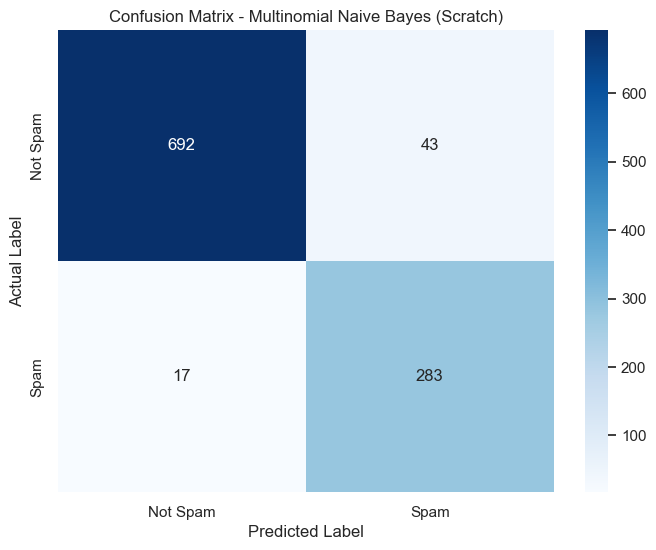

In [6]:
if 'cm' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Spam', 'Spam'], 
                yticklabels=['Not Spam', 'Spam'])
    plt.title('Confusion Matrix - Multinomial Naive Bayes (Scratch)')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

In [7]:
if 'y_pred' in locals():
    print("\n📋 Detailed Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))


📋 Detailed Classification Report:

              precision    recall  f1-score   support

    Not Spam       0.98      0.94      0.96       735
        Spam       0.87      0.94      0.90       300

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035

